In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext rpy2.ipython

In [3]:
# <%%R> has to be used in each cell with R-Code, with <%R> R-Code can be mixed with Python
%%R
df <- readRDS("/content/drive/MyDrive/Colab Notebooks/22-kostat-paper/cfa_jt_total.rda")

In [4]:
%%R
str(df)

'data.frame':	10623 obs. of  7 variables:
 $ 성취요인    : num  -1.219 -1.219 -0.219 -0.219 -1.219 ...
 $ 관계요인    : num  0.28 -1.72 -0.72 -0.72 -0.72 ...
 $ 여가요인    : num  0.861 -0.139 -0.139 -0.139 -0.139 ...
 $ 소득요인    : num  -0.9134 0.0866 1.0866 -0.9134 1.0866 ...
 $ 소비요인    : num  -0.0104 -0.0104 0.9896 -0.0104 -1.0104 ...
 $ 근로여건요인: num  -0.276 0.295 -0.416 -0.538 0.488 ...
 $ 주관적만족감: Factor w/ 2 levels "불만족","만족": 1 1 2 2 1 2 2 2 1 2 ...


In [13]:
# %%R
# install.packages("tidyverse")
# install.packages("caret")
# install.packages("h2o")
# install.packages("MLmetrics")
# install.packages("yardstick")
# install.packages("pROC")
# install.packages("DALEX")
# install.packages("DALEXtra")

In [15]:
%%R

library(tidyverse)
library(caret)
library(h2o)

library(MLmetrics)
library(yardstick)
library(pROC)

library(DALEX)
library(DALEXtra)

# 2 classfication Model using h2o package

## AutoML Model

In [16]:
## h2o
%%R
str(df)

'data.frame':	10623 obs. of  7 variables:
 $ 성취요인    : num  -1.219 -1.219 -0.219 -0.219 -1.219 ...
 $ 관계요인    : num  0.28 -1.72 -0.72 -0.72 -0.72 ...
 $ 여가요인    : num  0.861 -0.139 -0.139 -0.139 -0.139 ...
 $ 소득요인    : num  -0.9134 0.0866 1.0866 -0.9134 1.0866 ...
 $ 소비요인    : num  -0.0104 -0.0104 0.9896 -0.0104 -1.0104 ...
 $ 근로여건요인: num  -0.276 0.295 -0.416 -0.538 0.488 ...
 $ 주관적만족감: Factor w/ 2 levels "불만족","만족": 1 1 2 2 1 2 2 2 1 2 ...


In [17]:
%%R
## h2o
set.seed(2022)
idx <- createDataPartition(df$주관적만족감, p = .7, list = F)

# Train, Test Set
h2o.init()
train <- as.h2o(df[idx, ])
test  <- as.h2o(df[-idx, ])

test_y <- df[-idx,"주관적만족감"] # for Metric

# Identify predictors and response
y <- "주관적만족감"
x <- setdiff(names(train), y)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpgUEstS/file4575b12e66/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpgUEstS/file4538bdc1d1/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 274 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.1.2 
    H2O cluster version age:    2 months and 28 days  
    H2O cluster name:           H2O_started_from_R_root_okz590 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:   

In [18]:
%%R
nfolds = 10

In [19]:
%%R
# Run AutoML for 20 base models
aml <- h2o.automl(x = x, y = y,
                  training_frame = train,
                  nfolds = nfolds,
                  keep_cross_validation_predictions = TRUE,
                  max_models = 20,
                  seed = 2022)

  |======================================================================| 100%


In [24]:
%%R
aml

AutoML Details
Project Name: AutoML_1_20220823_150646 
Leader Model ID: StackedEnsemble_AllModels_1_AutoML_1_20220823_150646 
Algorithm: stackedensemble 

Total Number of Models Trained: 22 
Start Time: 2022-08-23 15:06:47 UTC 
End Time: 2022-08-23 15:48:11 UTC 
Duration: 2484 s

Leaderboard
                                                  model_id       auc   logloss
1     StackedEnsemble_AllModels_1_AutoML_1_20220823_150646 0.8504454 0.3225869
2              GBM_grid_1_AutoML_1_20220823_150646_model_2 0.8503385 0.3238791
3                           GBM_1_AutoML_1_20220823_150646 0.8502322 0.3235268
4  StackedEnsemble_BestOfFamily_1_AutoML_1_20220823_150646 0.8501366 0.3228421
5                           GBM_5_AutoML_1_20220823_150646 0.8484472 0.3259684
6                           GBM_2_AutoML_1_20220823_150646 0.8481535 0.3254669
7              GBM_grid_1_AutoML_1_20220823_150646_model_1 0.8481373 0.3256219
8                       XGBoost_3_AutoML_1_20220823_150646 0.8451803 0.3281

In [34]:
%%R
model_stack <- h2o.getModel("StackedEnsemble_AllModels_1_AutoML_1_20220823_150646")

In [35]:
%%R
summary(model_stack)

Model Details:

H2OBinomialModel: stackedensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220823_150646 
Number of Base Models: 20

Base Models (count by algorithm type):

deeplearning          drf          gbm          glm      xgboost 
           4            2            7            1            6 

Metalearner:

Metalearner algorithm: glm
Metalearner cross-validation fold assignment:
  Fold assignment scheme: AUTO
  Number of folds: 10
  Fold column: NULL
Metalearner hyperparameters: 

H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.09028639
RMSE:  0.3004769
LogLoss:  0.300877
Mean Per-Class Error:  0.227169
AUC:  0.8754238
AUCPR:  0.6608811
Gini:  0.7508476

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
       만족 불만족    Error       Rate
만족   5686    488 0.079041  =488/6174
불만족  474    789 0.375297  =474/1263
Totals 6160   1277 0.129353  =962/7437

Maximum Metrics: Maximum metrics at their respective thres

In [36]:
%%R
pred.h2o <- h2o.predict(model_stack, test)
pred_y <- as.factor(as.vector(pred.h2o$predict))
pred_y <- fct_rev(pred_y) # 불만족(참조변수), 만족(관심변수)

  |======================================================================| 100%


In [37]:
%%R
confusionMatrix(as.factor(test_y), as.factor(pred_y), positive="만족")

Confusion Matrix and Statistics

          Reference
Prediction 불만족 만족
    불만족    335  205
    만족      307 2339
                                          
               Accuracy : 0.8393          
                 95% CI : (0.8261, 0.8519)
    No Information Rate : 0.7985          
    P-Value [Acc > NIR] : 2.122e-09       
                                          
                  Kappa : 0.4691          
                                          
 Mcnemar's Test P-Value : 8.059e-06       
                                          
            Sensitivity : 0.9194          
            Specificity : 0.5218          
         Pos Pred Value : 0.8840          
         Neg Pred Value : 0.6204          
             Prevalence : 0.7985          
         Detection Rate : 0.7341          
   Detection Prevalence : 0.8305          
      Balanced Accuracy : 0.7206          
                                          
       'Positive' Class : 만족            
                              

In [40]:
%%R
round(MLmetrics::Accuracy(test_y, pred_y), 2)

[1] 0.84


In [41]:
%%R
round(MLmetrics::F1_Score(test_y, pred_y, positive="만족"), 2)

[1] 0.9


In [42]:
%%R
round(MLmetrics::Precision(test_y, pred_y, positive="만족"), 2)

[1] 0.92


In [43]:
%%R
round(MLmetrics::Recall(test_y, pred_y, positive="만족"), 2)

[1] 0.88


## Custom Model


In [45]:
%%R
################
# CUSTOM MODEL
################
# Set number of folds for base learners
nfolds <- 10

### Train & Cross-validate a GLM model

In [51]:
%%R
# https://docs.h2o.ai/h2o-tutorials/latest-stable/tutorials/glm/glm.html
model_glm = h2o.glm(x = x, y = y,
                    training_frame = train,
                    nfolds = nfolds,
                    keep_cross_validation_predictions = TRUE,
                    family='binomial',
                    seed=1)

  |======================================================================| 100%


### Train & Cross-validate a GBM model

In [53]:
%%R
model_gbm <- h2o.gbm(x = x, y = y,
                     training_frame = train,
                     distribution = "bernoulli",
                     ntrees = 100,
                     nfolds = nfolds,
                     keep_cross_validation_predictions = TRUE,
                     seed = 1)

  |======================================================================| 100%


### Train & Cross-validate an RF model

In [54]:
%%R
model_rf <- h2o.randomForest(x = x, y = y,
                             training_frame = train,
                             ntrees = 100,
                             nfolds = nfolds,
                             keep_cross_validation_predictions = TRUE,
                             seed = 1)

  |======================================================================| 100%


### Train & Cross-validate an DL model

In [55]:
%%R
model_dl <- h2o.deeplearning(x = x, y = y,
                             training_frame = train,
                             nfolds = nfolds,
                             keep_cross_validation_predictions = TRUE,
                             seed = 1)

  |======================================================================| 100%


### Train & Cross-validate an XGB model

In [58]:
%%R
# Build and train the model:
model_xgb <- h2o.xgboost(x = x, y = y,
                         training_frame = train,
                         distribution = 'bernoulli',
                         normalize_type = "tree",
                         #  booster = "gbtree", "dart", "gblinear"
                         nfolds = nfolds,
                         keep_cross_validation_predictions = TRUE,
                         seed = 1)

  |======================================================================| 100%


## 성능 평가




In [68]:
%%R
perf <- h2o.performance(model_stack, test)
auroc <- h2o.auc(perf)
round(auroc, 2)

[1] 0.84


In [69]:
%%R
pred.h2o <- h2o.predict(model_stack, test)
pred_y <- as.factor(as.vector(pred.h2o$predict))
pred_y <- fct_rev(pred_y) # 불만족(참조변수), 만족(관심변수)

  |======================================================================| 100%


In [70]:
%%R
round(MLmetrics::Accuracy(test_y, pred_y), 2)

[1] 0.84


In [71]:
%%R
round(MLmetrics::F1_Score(test_y, pred_y, positive="만족"), 2)

[1] 0.9


In [72]:
%%R
round(MLmetrics::Precision(test_y, pred_y, positive="만족"), 2)

[1] 0.92


In [73]:
%%R
round(MLmetrics::Recall(test_y, pred_y, positive="만족"), 2)

[1] 0.88


### ROC Curve


### ggROC

In [74]:
%%R
# install.packages("pROC")
library('pROC')

In [76]:
%%R
prob_y <- predict(model_stack, test, type="prob")[,"만족"]

  |======================================================================| 100%


In [77]:
%%R
prob_y <- as.data.frame(prob_y)[,"만족"]
str(prob_y)

 num [1:3186] 0.857 0.99 0.752 0.926 0.946 ...


In [78]:
%%R
roc.object <- pROC::roc(test_y, prob_y)

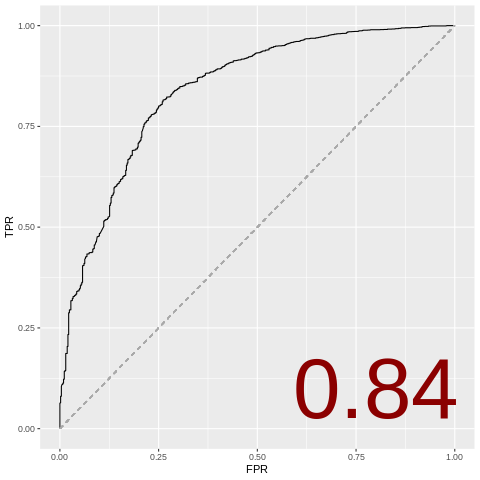

In [79]:
%%R
# g <- ggroc(roc.object)
gl <- ggroc(roc.object, legacy.axes = TRUE)
gl + xlab("FPR") + ylab("TPR") + 
    geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), color="darkgrey", linetype="dashed") +
    annotate("text", x=0.8, y=0.1, label=round(auroc,2), color="darkred", size=30)
    # +
    # annotate("text", x=0.1, y=1, label="ROC Curve", color="Black", size=7.5)

## 모델 저장

In [80]:
%%R
# Save model
path = "/content/drive/MyDrive/Colab Notebooks/22-kostat-paper"
h2o.saveModel(my_stack, path, filename="model_stack_total")

[1] "/content/drive/MyDrive/Colab Notebooks/22-kostat-paper/model_stack_total"


## 변수 중요도

In [81]:
%%R
# convert feature variables to a data frame - tibble is also a data frame 
x_valid <- test %>% as.data.frame %>% select(-"주관적만족감") %>% as_tibble()
# change response variable to a numeric binary vector
y_valid <- as.vector(as.numeric(test$주관적만족감))

In [82]:
%%R
str(y_valid)

 int [1:3186] 0 0 1 0 0 0 1 0 0 0 ...


In [83]:
%%R
# create custom predict function
pred <- function(model, newdata)  {
  results <- as.data.frame(h2o.predict(model, newdata %>% as.h2o()))
  return(results[[3L]])
  }

In [91]:
%%R
explainer_dl <- explain(
  model            = model_dl, 
  type             = "classification",
  data             = x_valid,
  y                = y_valid,
  predict_function = pred,
  label            = "h2o_deeplearning"
  )

Preparation of a new explainer is initiated
  -> model label       :  h2o_deeplearning 
  -> data              :  3186  rows  6  cols 
  -> data              :  tibble converted into a data.frame 
  -> target variable   :  3186  values 
  -> predict function  :  pred 
  -> predicted values  :  No value for predict function target column. (  default  )
  |======================================================================| 100%
  |======================================================================| 100%
  -> model_info        :  package h2o , ver. 3.36.1.2 , task classification (  default  ) 
  -> model_info        :  type set to  classification 
  |======================================================================| 100%
  |======================================================================| 100%
  -> predicted values  :  numerical, min =  0.001906493 , mean =  0.1676479 , max =  0.9279144  
  -> residual function :  difference between y and yhat (  default  )
  |==========

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

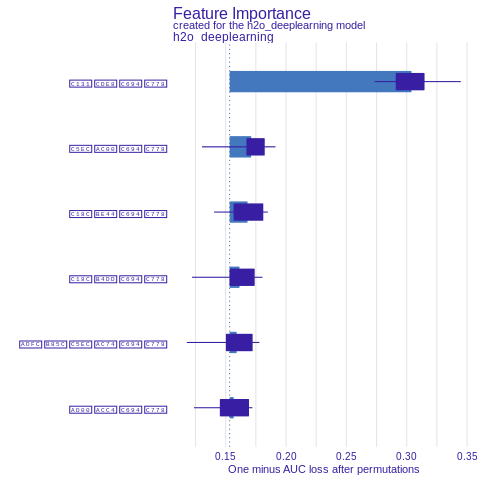

In [93]:
%%R
fi_dl <- model_parts(explainer_dl)
plot(fi_dl)